In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.BAI_FixedBudget import *
from codes.Environment import Mixture_AbsGau, setup_env, Exp
from codes.SimulatedGames import simulate
from codes.plots import *

%matplotlib inline

In [2]:
rewards_array = np.load('rewards.npy')

In [3]:
class Vaccine_Env():
    """Env for Exponential Distribution.
    """
    def __init__(self, reward):
        self.reward = reward

    def sample(self, size = None):
        return np.random.choice(self.reward)

    def est_hazard_rate(self,bandwidth = 0.005):
        sorted_reward = np.sort(self.reward)
        x_list = np.arange(sorted_reward[0], sorted_reward[-1], 0.01)
        est_h_list = []
        for i, x in enumerate(x_list):
            count1 = 0
            count2 = 0
            for reward in sorted_reward:
                if x <= reward <= x + bandwidth:
                    count1 +=1
                if x<= reward:
                    count2+=1
            est_h = count1/count2/bandwidth
            est_h_list.append(est_h)

        plt.scatter(x_list, est_h_list)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


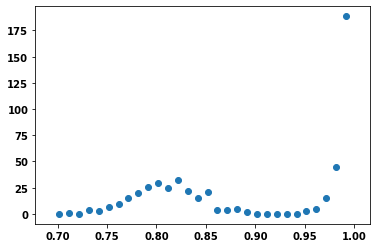

In [4]:
Vaccine_Env(rewards_array[10]).est_hazard_rate()

In [5]:
def setup_env(rewards_array, ss_list = ['quantile_0.5'], random_set = None):
    """Setup environment for Vaccine simulations.
    """
    
    rewards_env = defaultdict(list)
    true_ss_dict = {}

    name = 'vaccine'
    true_ss_dict[name] = defaultdict(list)

    for arm_no, reward in enumerate(rewards_array):
        
        current_env = Vaccine_Env(reward)
                
        rewards_env[name].append(current_env)
                
        for ss in ss_list:
            ss_name = ss.split('_')[0]
            if len(ss.split('_'))> 1:
                ss_para = float(ss.split('_')[-1])
            if ss_name == 'quantile':
                true_ss_dict[name][ss].append(np.quantile(reward, ss_para))
            elif ss_name == 'mean':
                true_ss_dict[name][ss_name].append(np.mean(reward))
            else:
                assert True, 'Unknown summary statistics!'

    return rewards_env, true_ss_dict

In [6]:
# quantile_list = []
# mean_list = []
# tau = 0.5

# for i, reward in enumerate(rewards_array):
#     plt.hist(reward)
#     quantile_list.append(np.quantile(reward, tau))
#     mean_list.append(np.mean(reward))
#     print(i)
#     print('median: ', np.quantile(reward, tau))
#     print('mean: ', np.mean(reward))
# plt.xlabel('vaccine rewards')
# plt.title('Histogram')

In [7]:
rewards_env, true_ss_dict = setup_env(rewards_array, ['quantile_0.5'])

In [8]:
np.sort(true_ss_dict['vaccine']['quantile_0.5'])

array([0.7585   , 0.767116 , 0.773113 , 0.77317  , 0.774    , 0.7745   ,
       0.7745565, 0.775225 , 0.775612 , 0.775612 , 0.775862 , 0.7765   ,
       0.776556 , 0.7773055, 0.778666 , 0.782    , 0.7861605, 0.786357 ,
       0.789    , 0.789    , 0.789105 , 0.789211 , 0.792104 , 0.792802 ,
       0.7964535, 0.7973515, 0.8056455, 0.806895 , 0.8074905, 0.812297 ,
       0.8215   , 0.832    ])

In [9]:
def run_exper(rewards_env, summary_stats, policy, epsilon, m, budget, num_exper, 
              fixed_samples_list = None):
    for key in rewards_env.keys():
        name = key + '_' + str(num_exper)
        policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
        subname = policy_name  + str(budget) 
        p = IntProgress(max = num_exper)
        p.description = 'Running'
        display(p)
        results[name][subname] = []

        result = simulate(rewards_env[key],summary_stats[key], policy, 
                epsilon, m, budget, num_exper, p, fixed_samples_list)
        results[name][subname].append(result)

In [10]:

results = defaultdict(dict)

num_exper = 5000
epsilon = 0
m = 1

In [11]:
for budget in [1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000]:
# for budget in [500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]:
# for budget in [500]:
    # run_exper(rewards_env, true_ss_dict, Q_SAR_Simplified_Large_Margin, epsilon, m, budget, num_exper)

    # run_exper(rewards_env, true_ss_dict, Q_SAR, epsilon, m, budget, num_exper)
    run_exper(rewards_env, true_ss_dict, Q_SR, epsilon, m, budget, num_exper)

    run_exper(rewards_env, true_ss_dict, Q_SAR_Simplified, epsilon, m, budget, num_exper)

    # run_exper(rewards_env, true_ss_dict, OS_SAR_Simplified, epsilon, m, budget, num_exper)

    run_exper(rewards_env, true_ss_dict, batch_elimination, epsilon, m, budget, num_exper)

    run_exper(rewards_env, true_ss_dict, uniform_sampling, epsilon, m, budget, num_exper)

IntProgress(value=0, description='Running', max=5000)

KeyboardInterrupt: 

Budget Probability of Error  std Policy
0    500                  NaN  NaN   Q-BS
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


,Budget,Probability of Error,std,Policy
0,500,NaN,NaN,Q-BS


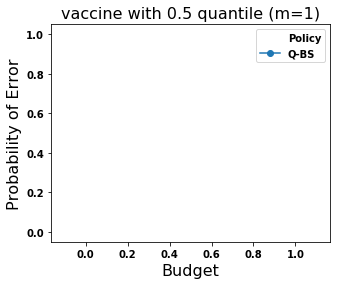

In [12]:
# save results

with open('../vaccine_m1_05quant_budget_5000.pickle', 'wb') as handle:
     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('../Group_One_Fixed_Budget.pickle', 'rb') as handle:
#     results = pickle.load(handle)

plot_eva_budget(results, 'pe', paper_flag = True, with_para = True, title = 'vaccine with 0.5 quantile (m=1)', log_scale = False)